<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/TesteRede2_Binaria_Base3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install imutils

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from skimage import transform

import cv2
import csv
import imutils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


## Funções

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao



---

*  [Keras, output of model predict_proba](https://stackoverflow.com/questions/41716380/keras-output-of-model-predict-proba/41729210#41729210)
*  [keras: what is the difference between model.predict and model.predict_proba](https://stackoverflow.com/questions/40747679/keras-what-is-the-difference-between-model-predict-and-model-predict-proba)



In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Segmentado/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
           
            # Probabilidade de ser da classe 1
            prob.append(predicao[0][1])
            
            # Se é um cromossomo:
            if predicao[0][1] > predicao[0][0]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob




---



# Implementação



*   Batch size = 32
*   Image size = 120x120



## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado3/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado3/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado3/Validation'

In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [0]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4230 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [0]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa - Test Precision: 19.64%, AUC: 0.465, Accuracy: 19.64%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 87s - loss: 0.8072 - acc: 0.4937 - val_loss: 0.7013 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 0.70130, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 2/50
 - 84s - loss: 0.7047 - acc: 0.4562 - val_loss: 0.6929 - val_acc: 0.5156

Epoch 00002: val_loss improved from 0.70130 to 0.69290, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 3/50
 - 85s - loss: 0.6953 - acc: 0.5000 - val_loss: 0.6917 - val_acc: 0.6562

Epoch 00003: val_loss improved from 0.69290 to 0.69171, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 4/50
 - 80s - loss: 0.7066 - acc: 0.4750 - val_loss: 0.6818 - val_acc: 0.5781

Epoch 00004: val_loss improved from 0.69171 to 0.68177, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 5/50
 - 80s - loss: 0.7008 - acc: 0.4937 - val_loss: 0.6840 - val_acc: 0.5938

Epoch 00005: val_loss did not impro

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

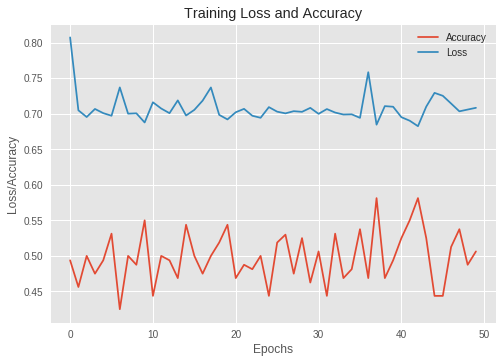

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.465, Accuracy: 19.64%


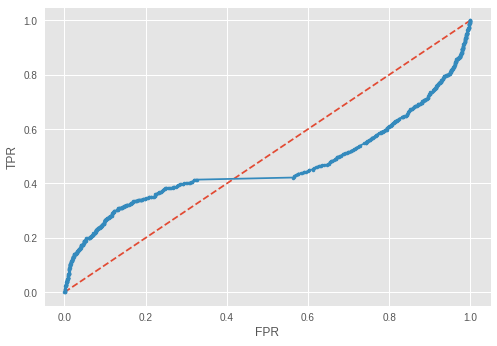

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 2 tentativa - Test Precision: 19.60%, AUC: 0.605, Accuracy: 20.07%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6929 - acc: 0.5187 - val_loss: 0.6919 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 0.69194, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6921 - acc: 0.6000 - val_loss: 0.6918 - val_acc: 0.8906

Epoch 00002: val_loss improved from 0.69194 to 0.69180, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6913 - acc: 0.7226 - val_loss: 0.6916 - val_acc: 0.8594

Epoch 00003: val_loss improved from 0.69180 to 0.69156, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6902 - acc: 0.6437 - val_loss: 0.6909 - val_acc: 0.5312

Epoch 00004: val_loss improved from 0.69156 to 0.69091, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 5/50
 - 1s - loss: 0.6904 - acc: 0.7750 - val_loss: 0.6910 - val_acc: 0.8281

Epoch 00005: val_loss did not improve fr

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

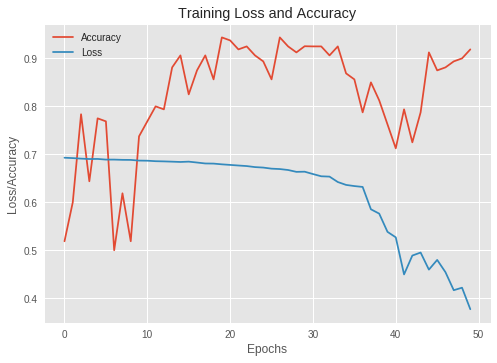

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.60%, AUC: 0.605, Accuracy: 20.07%


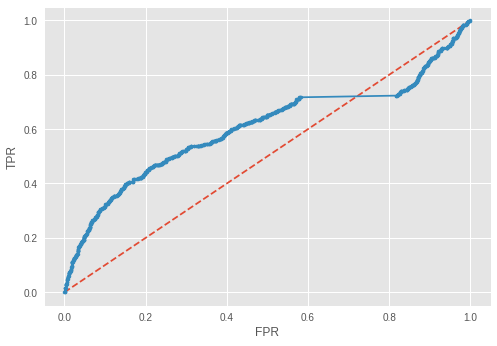

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 3 tentativa - Test Precision: 19.64%, AUC: 0.092, Accuracy: 19.64%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 4.3377 - acc: 0.5594 - val_loss: 2.7793 - val_acc: 0.5859

Epoch 00001: val_loss improved from inf to 2.77932, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 2/50
 - 0s - loss: 3.8035 - acc: 0.5219 - val_loss: 1.5422 - val_acc: 0.7266

Epoch 00002: val_loss improved from 2.77932 to 1.54221, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 3/50
 - 0s - loss: 2.8078 - acc: 0.6531 - val_loss: 1.0899 - val_acc: 0.8047

Epoch 00003: val_loss improved from 1.54221 to 1.08990, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 4/50
 - 0s - loss: 1.6601 - acc: 0.7313 - val_loss: 0.8998 - val_acc: 0.8984

Epoch 00004: val_loss improved from 1.08990 to 0.89981, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 5/50
 - 0s - loss: 0.9158 - acc: 0.8187 - val_loss: 1.2909 - val_acc: 0.8750

Epoch 00005: val_loss did not improve fr

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

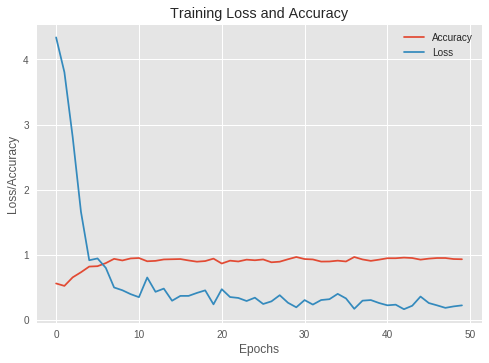

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.092, Accuracy: 19.64%


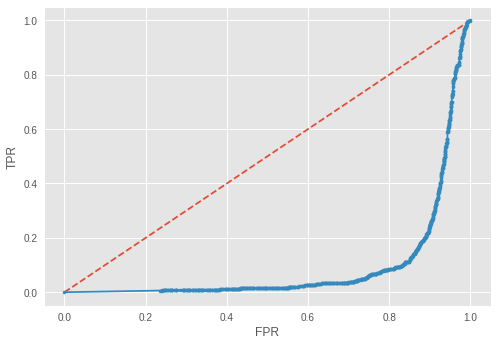

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 4 tentativa - Test Precision: 24.75%, AUC: 0.945, Accuracy: 40.53%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.4203 - acc: 0.8594 - val_loss: 1.4812 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 1.48115, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 2/50
 - 0s - loss: 0.3801 - acc: 0.9031 - val_loss: 0.5696 - val_acc: 0.9141

Epoch 00002: val_loss improved from 1.48115 to 0.56964, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 3/50
 - 0s - loss: 0.2847 - acc: 0.9219 - val_loss: 0.4870 - val_acc: 0.8359

Epoch 00003: val_loss improved from 0.56964 to 0.48695, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 4/50
 - 0s - loss: 0.2081 - acc: 0.9375 - val_loss: 0.7179 - val_acc: 0.8047

Epoch 00004: val_loss did not improve from 0.48695
Epoch 5/50
 - 0s - loss: 0.2080 - acc: 0.9344 - val_loss: 0.9485 - val_acc: 0.6641

Epoch 00005: val_loss did not improve from 0.48695
Epoch 6/50
 - 0s - loss: 0.4583 - acc: 0.8563 - val_loss: 2.4220 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

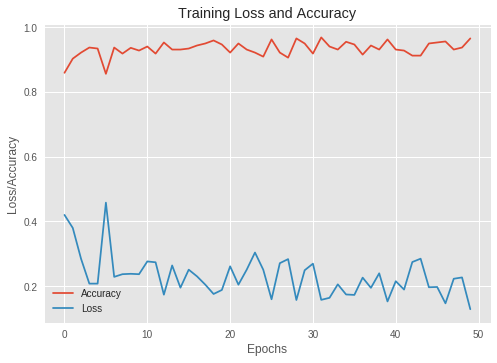

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 24.75%, AUC: 0.945, Accuracy: 40.53%


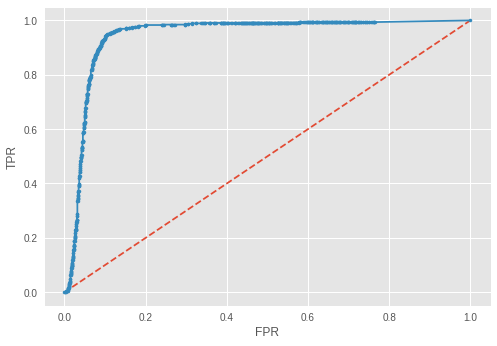

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 5 tentativa - Test Precision: 19.64%, AUC: 0.100, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 4.4782 - acc: 0.5656 - val_loss: 0.7231 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.72313, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 2/50
 - 0s - loss: 3.1188 - acc: 0.6000 - val_loss: 0.8292 - val_acc: 0.7891

Epoch 00002: val_loss did not improve from 0.72313
Epoch 3/50
 - 0s - loss: 1.6075 - acc: 0.7594 - val_loss: 1.9704 - val_acc: 0.8047

Epoch 00003: val_loss did not improve from 0.72313
Epoch 4/50
 - 0s - loss: 0.6332 - acc: 0.9031 - val_loss: 0.8110 - val_acc: 0.8359

Epoch 00004: val_loss did not improve from 0.72313
Epoch 5/50
 - 0s - loss: 1.3611 - acc: 0.8156 - val_loss: 0.6432 - val_acc: 0.9375

Epoch 00005: val_loss improved from 0.72313 to 0.64320, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 6/50
 - 0s - loss: 0.8278 - acc: 0.8875 - val_loss: 0.9840 - val_acc: 0.8125

Epoch 00006: val_loss did not improve from 0.64320
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

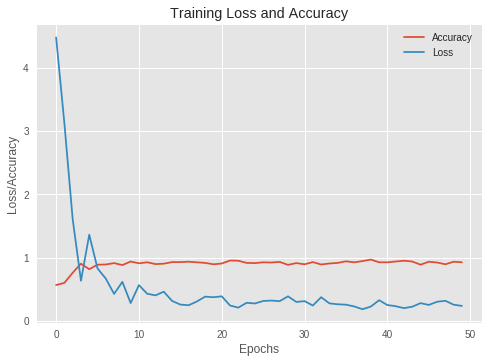

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.100, Accuracy: 19.64%


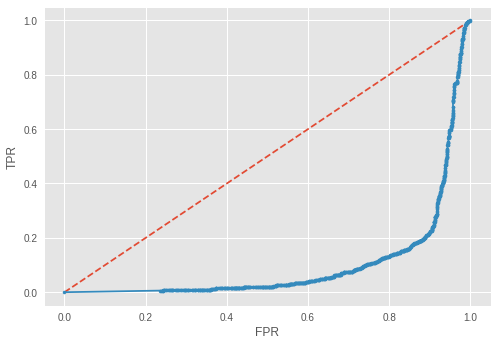

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 6 tentativa - Test Precision: 53.06%, AUC: 0.573, Accuracy: 80.54%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.4629 - acc: 0.8063 - val_loss: 0.9236 - val_acc: 0.7266

Epoch 00001: val_loss improved from inf to 0.92357, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.3889 - acc: 0.8750 - val_loss: 0.7400 - val_acc: 0.7656

Epoch 00002: val_loss improved from 0.92357 to 0.74001, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.3293 - acc: 0.9062 - val_loss: 4.0966 - val_acc: 0.6953

Epoch 00003: val_loss did not improve from 0.74001
Epoch 4/50
 - 0s - loss: 0.2806 - acc: 0.9313 - val_loss: 1.5783 - val_acc: 0.6705

Epoch 00004: val_loss did not improve from 0.74001
Epoch 5/50
 - 0s - loss: 0.3445 - acc: 0.9000 - val_loss: 0.5339 - val_acc: 0.8359

Epoch 00005: val_loss improved from 0.74001 to 0.53393, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 6/50
 - 0s - loss: 0.2653 - acc: 0.9156 - val_loss: 0.4434 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

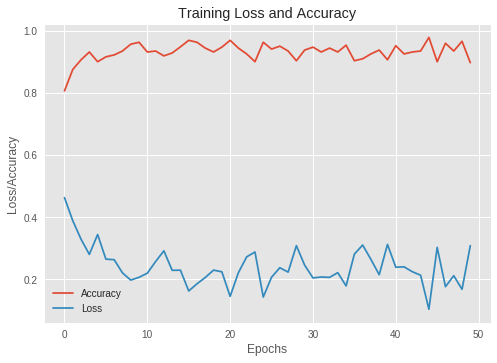

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 53.06%, AUC: 0.573, Accuracy: 80.54%


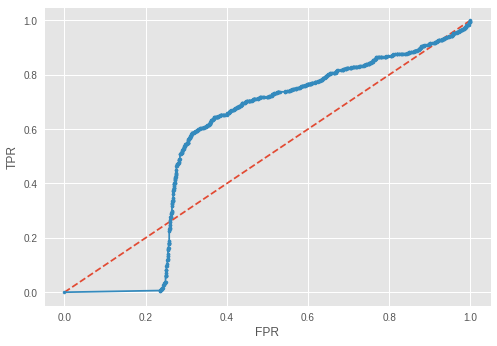

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 7 tentativa - Test Precision: 74.34%, AUC: 0.934, Accuracy: 90.44%

Modelo adaptado do  **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.4287 - acc: 0.8375 - val_loss: 1.6950 - val_acc: 0.6364

Epoch 00001: val_loss improved from inf to 1.69503, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.2645 - acc: 0.9281 - val_loss: 0.5033 - val_acc: 0.8594

Epoch 00002: val_loss improved from 1.69503 to 0.50325, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 3/50
 - 0s - loss: 0.2822 - acc: 0.9156 - val_loss: 0.5464 - val_acc: 0.8203

Epoch 00003: val_loss did not improve from 0.50325
Epoch 4/50
 - 1s - loss: 0.2938 - acc: 0.9125 - val_loss: 0.6929 - val_acc: 0.7812

Epoch 00004: val_loss did not improve from 0.50325
Epoch 5/50
 - 0s - loss: 0.2702 - acc: 0.9250 - val_loss: 0.8846 - val_acc: 0.6328

Epoch 00005: val_loss did not improve from 0.50325
Epoch 6/50
 - 1s - loss: 0.3677 - acc: 0.9000 - val_loss: 0.4850 - val_acc: 0.8125

Epoch 00006: val_loss improved from 0.50325 to 0.48504, saving model to dri

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

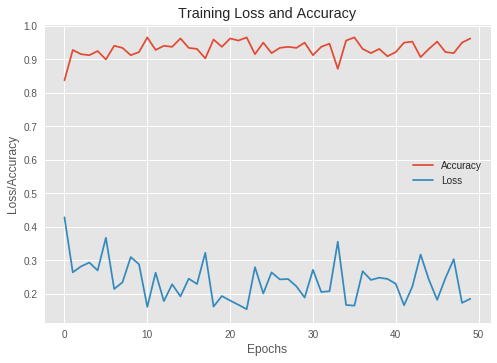

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 74.34%, AUC: 0.934, Accuracy: 90.44%


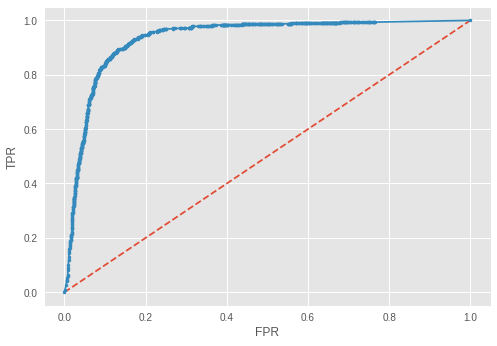

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 8 tentativa - Test Precision: 19.64%, AUC: 0.930, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 3.8318 - acc: 0.5531 - val_loss: 4.1119 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 4.11189, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 4.0788 - acc: 0.5531 - val_loss: 0.4161 - val_acc: 0.8906

Epoch 00002: val_loss improved from 4.11189 to 0.41609, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 3/50
 - 1s - loss: 2.3743 - acc: 0.6344 - val_loss: 0.6724 - val_acc: 0.8750

Epoch 00003: val_loss did not improve from 0.41609
Epoch 4/50
 - 1s - loss: 1.2085 - acc: 0.8250 - val_loss: 0.8135 - val_acc: 0.8281

Epoch 00004: val_loss did not improve from 0.41609
Epoch 5/50
 - 1s - loss: 0.6798 - acc: 0.8375 - val_loss: 0.6220 - val_acc: 0.8828

Epoch 00005: val_loss did not improve from 0.41609
Epoch 6/50
 - 1s - loss: 0.5074 - acc: 0.8969 - val_loss: 0.5353 - val_acc: 0.9062

Epoch 00006: val_loss did not improve from 0.41609
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

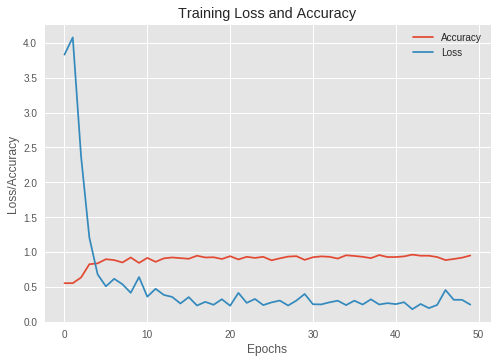

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.930, Accuracy: 19.64%


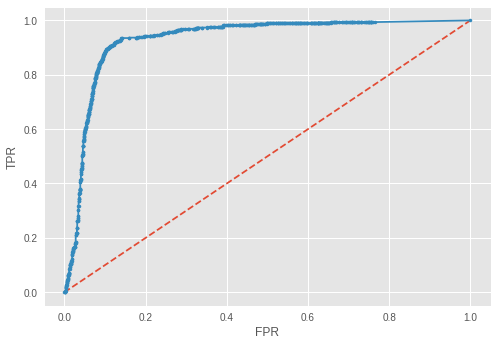

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 9 tentativa - Test Precision: 19.64%, AUC: 0.073, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 7.3439 - acc: 0.5031 - val_loss: 7.3042 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 7.30418, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 2/50
 - 0s - loss: 7.9011 - acc: 0.5000 - val_loss: 8.0117 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 7.30418
Epoch 3/50
 - 0s - loss: 7.8195 - acc: 0.4844 - val_loss: 8.0117 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 7.30418
Epoch 4/50
 - 0s - loss: 7.3553 - acc: 0.4813 - val_loss: 4.8522 - val_acc: 0.5234

Epoch 00004: val_loss improved from 7.30418 to 4.85221, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 5/50
 - 0s - loss: 6.3381 - acc: 0.5438 - val_loss: 4.9588 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 4.85221
Epoch 6/50
 - 0s - loss: 4.6945 - acc: 0.5781 - val_loss: 4.9920 - val_acc: 0.6406

Epoch 00006: val_loss did not improve from 4.85221
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

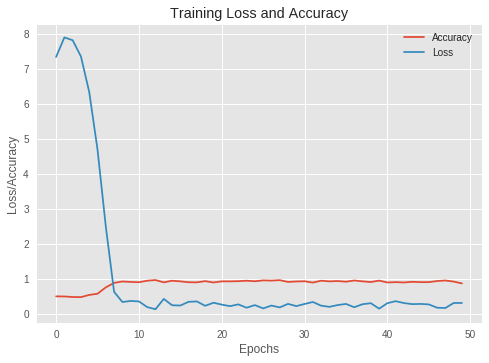

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.073, Accuracy: 19.64%


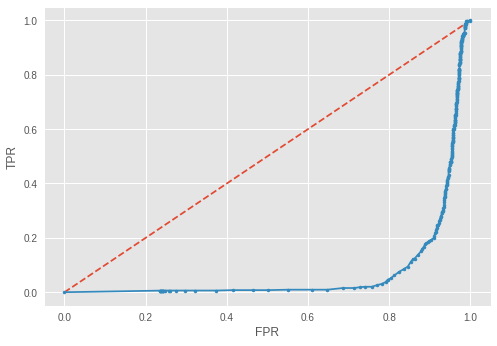

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 10 tentativa - Test Precision: 19.64%, AUC: 0.247, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 2.4938 - acc: 0.5406 - val_loss: 1.4215 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.42153, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.3360 - acc: 0.6250 - val_loss: 0.4777 - val_acc: 0.8281

Epoch 00002: val_loss improved from 1.42153 to 0.47769, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 3/50
 - 1s - loss: 0.8997 - acc: 0.7562 - val_loss: 1.7157 - val_acc: 0.5469

Epoch 00003: val_loss did not improve from 0.47769
Epoch 4/50
 - 1s - loss: 0.7817 - acc: 0.7781 - val_loss: 0.2371 - val_acc: 0.9375

Epoch 00004: val_loss improved from 0.47769 to 0.23707, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 5/50
 - 1s - loss: 0.5259 - acc: 0.8344 - val_loss: 0.3181 - val_acc: 0.9141

Epoch 00005: val_loss did not improve from 0.23707
Epoch 6/50
 - 1s - loss: 0.4931 - acc: 0.8781 - val_loss: 0.5406 - val_

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

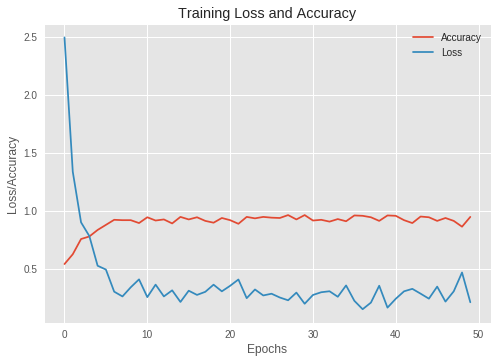

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.247, Accuracy: 19.64%


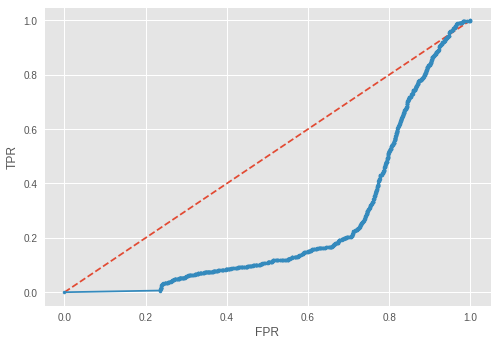

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 11 tentativa - Test Precision: 19.64%, AUC: 0.283, Accuracy: 19.64%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 3.3316 - acc: 0.4844 - val_loss: 0.8348 - val_acc: 0.5156

Epoch 00001: val_loss improved from inf to 0.83485, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 2/50
 - 0s - loss: 2.3012 - acc: 0.5210 - val_loss: 0.8943 - val_acc: 0.6016

Epoch 00002: val_loss did not improve from 0.83485
Epoch 3/50
 - 1s - loss: 1.2229 - acc: 0.6031 - val_loss: 0.6213 - val_acc: 0.7656

Epoch 00003: val_loss improved from 0.83485 to 0.62134, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 4/50
 - 1s - loss: 0.8076 - acc: 0.7031 - val_loss: 0.4467 - val_acc: 0.8906

Epoch 00004: val_loss improved from 0.62134 to 0.44674, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 5/50
 - 1s - loss: 0.4637 - acc: 0.8250 - val_loss: 0.8427 - val_acc: 0.7656

Epoch 00005: val_loss did not improve from 0.44674
Epoch 6/50
 - 1s - loss: 0.4065 - acc: 0.8844 - val_loss: 0.4931 - val_

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

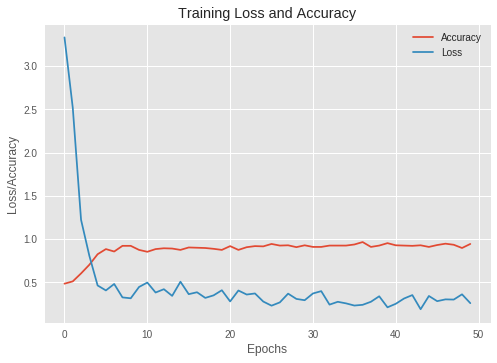

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.283, Accuracy: 19.64%


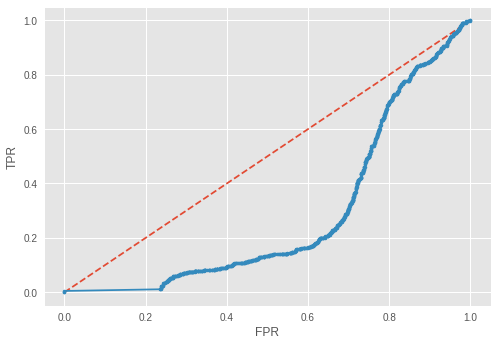

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 12 tentativa - Test Precision: 19.64%, AUC: 0.537, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 2.8203 - acc: 0.5250 - val_loss: 1.4147 - val_acc: 0.4062

Epoch 00001: val_loss improved from inf to 1.41473, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 2.7849 - acc: 0.5344 - val_loss: 1.1776 - val_acc: 0.6328

Epoch 00002: val_loss improved from 1.41473 to 1.17759, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 1.2864 - acc: 0.6562 - val_loss: 0.9301 - val_acc: 0.7266

Epoch 00003: val_loss improved from 1.17759 to 0.93007, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.5617 - acc: 0.8156 - val_loss: 0.6327 - val_acc: 0.8438

Epoch 00004: val_loss improved from 0.93007 to 0.63270, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 5/50
 - 0s - loss: 0.3373 - acc: 0.8887 - val_loss: 0.7701 - val_acc: 0.8047

Epoch 00005: val_loss did not improv

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

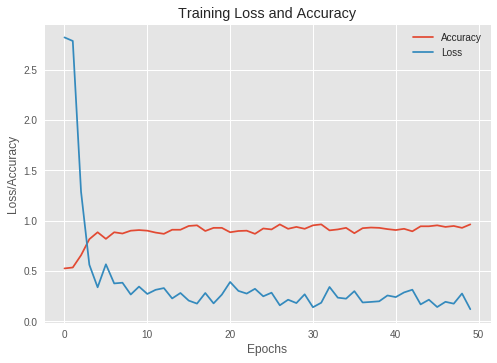

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.537, Accuracy: 19.64%


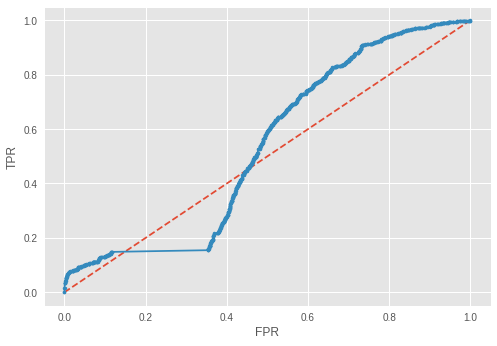

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 13 tentativa - Test Precision: 19.64%, AUC: 0.379, Accuracy: 19.64%

Modelo adaptado do **Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.0886 - acc: 0.6375 - val_loss: 0.2342 - val_acc: 0.9609

Epoch 00001: val_loss improved from inf to 0.23417, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.6323 - acc: 0.7969 - val_loss: 0.2578 - val_acc: 0.9219

Epoch 00002: val_loss did not improve from 0.23417
Epoch 3/50
 - 0s - loss: 0.3445 - acc: 0.8875 - val_loss: 0.8093 - val_acc: 0.8068

Epoch 00003: val_loss did not improve from 0.23417
Epoch 4/50
 - 0s - loss: 0.2447 - acc: 0.9344 - val_loss: 0.3969 - val_acc: 0.9141

Epoch 00004: val_loss did not improve from 0.23417
Epoch 5/50
 - 1s - loss: 0.2677 - acc: 0.9437 - val_loss: 0.3254 - val_acc: 0.8906

Epoch 00005: val_loss did not improve from 0.23417
Epoch 6/50
 - 1s - loss: 0.4274 - acc: 0.8937 - val_loss: 0.1957 - val_acc: 0.9375

Epoch 00006: val_loss improved from 0.23417 to 0.19569, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 7/50
 - 1s - los

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

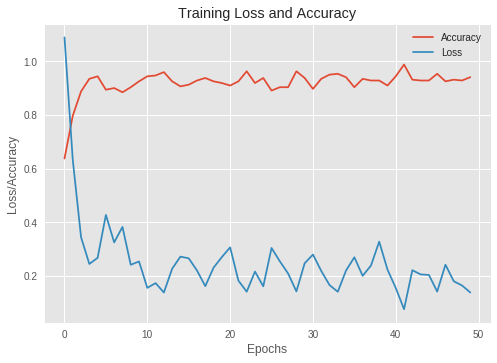

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 0.379, Accuracy: 19.64%


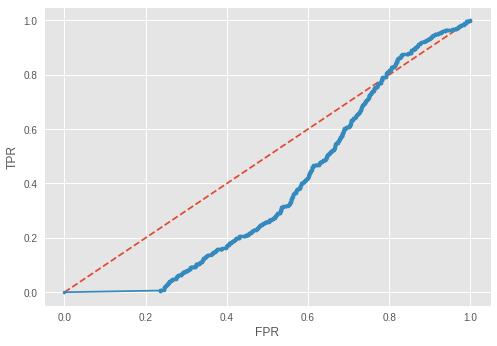

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## Mini VGG

In [0]:
architecture = 'miniVGG_base3_binaria'

### Modelo

In [0]:
def build_MiniVGG(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  
  inputShape = (height, width, depth)# first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same",
  input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  # return the constructed network architecture
  return model

In [0]:
model = build_MiniVGG(width=120, height=120, depth=3, classes=2)

opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Treino

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/' + 
                               'weights_' + architecture + '.hdf5', verbose=1,
                               save_best_only=True)

In [18]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 59s - loss: 0.8203 - acc: 0.7750 - val_loss: 1.0106 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 1.01062, saving model to drive/My Drive/Resultado/Segmentado/weights_miniVGG_base3_binaria.hdf5
Epoch 2/50
 - 52s - loss: 0.2832 - acc: 0.9000 - val_loss: 1.8954 - val_acc: 0.5156

Epoch 00002: val_loss did not improve from 1.01062
Epoch 3/50
 - 60s - loss: 0.1393 - acc: 0.9625 - val_loss: 0.5701 - val_acc: 0.7969

Epoch 00003: val_loss improved from 1.01062 to 0.57011, saving model to drive/My Drive/Resultado/Segmentado/weights_miniVGG_base3_binaria.hdf5
Epoch 4/50
 - 54s - loss: 0.3048 - acc: 0.9125 - val_loss: 3.7733 - val_acc: 0.4531

Epoch 00004: val_loss did not improve from 0.57011
Epoch 5/50
 - 59s - loss: 0.2184 - acc: 0.9313 - val_loss: 1.5209 - val_acc: 0.5938

Epoch 00005: val_loss did not improve from 0.57011
Epoch 6/50
 - 53s - loss: 0.2830 - acc: 0.9062 - val_loss: 0.6790 - val_acc: 0.8750

Epoch 0

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

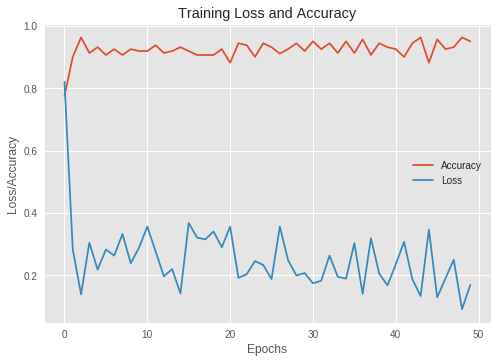

In [20]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [21]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.79%, AUC: 0.456, Accuracy: 21.80%


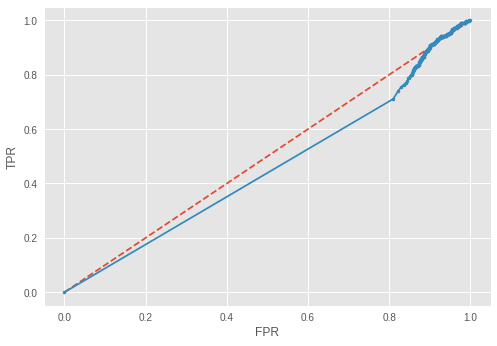

In [23]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')